<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>
<h1 style="line-height: 1.4;"><font color="#76b900"><b>GIL-free Python and the GPU</b></h1>
<h2>Practising parallel programming in Python, including its impact on the GPU.</h2>
<br>

**Welcome to the GIL-free Python and the GPU course!**

Since the earliest days of Python, the Global Interpreter Lock (GIL) has been a core aspect of CPython, simplifying the interpreter's design but at the cost of allowing only a single thread to run at a time, even on multi-core processors. Free-threaded Python addresses this issue by removing the GIL, thus allowing programmers to run threads in a truly parallel fashion and leveraging all the cores available in a system. This makes it possible to write parallel programs in ways that were previously impractical. In particular, this new paradigm enhances how Python programs interact with GPUs and offers a path to significant performance gains in some applications without having to leave Python. This workshop provides a hands-on introduction to this new approach to Python programming.

### **Learning Objectives:**
- **Analyze** the performance impact of the GIL and its removal.
- **Understand** the trade-offs between threading and processing.
- **Write** parallel applications using free-threaded Python.
- **Implement** thread-safe practices to prevent concurrency issues.
- **Optimize** GPU workflows by leveraging multi-threading.

# Setting up
The following section outlines, how to perform setup of the tutorial.

## Choosing the right interpreter

This tutorial is designed to compare the behavior of different Python versions. Since a Jupyter Notebook can only run one version of Python at a time, you can switch between them using the container dropdown menu located in the upper-right corner.

![Choosing the interpreter](../res/interpreter1.png)

Please be aware that the kernel will restart each time you select a new version - therefore after switching the kernel you should run all the previous cells in the notebook. This can be achieved with the `Run All Above Selected Cell` option in the `Run` drop-down menu above:

![Run All Above Selected Cell](../res/interpreter1.png)

To guide you, the specific cells whose output will differ depending on the Python version are marked with <span style="color:#76b900;font-size:120%"><img src="https://www.python.org/static/favicon.ico" alt="Python Icon" style="width:16px; vertical-align:middle;"> Python icon and our favourite green color</span>.

## Enabling profiler

In the course of this tutorial, we'll also learn to gather and read profiles on Python programs. We'll be using NVIDIA Nsight Systems profiler.
Before you begin, please make sure that the profiler in enabled. To do so, please make sure that `Profiling with Nsight Systems...` option is selected in the `NVIDIA Nsight` menu above:

![Enabling profiler](../res/profiler1.png)

### Display the viewer
When the profiler is enabled, please also select the option `Display Nsight UI via Nsight Streamer`. This will open the window with profile viewer. Gathered profiles will be opened in the viewer.

![Displaying viewer](../res/profiler2.png)

Here's how the viewer window should look after running it:

![UI](../res/profiler3.png)

# Hands-on experience

This tutorial is designed to give extensive hands-on experience. Whenever you see a **Task in bold**, together with *its description in italics* - it is your turn. Please take your time to complete the task, before going further with the tutorial. Usually the description provides links to documentation, feel free to use it! `solutions` directory provides, well... solutions, however I encourage you to use them only as a last resort. This is the way to ensure the biggest gain from completing this tutorial.

<hr><br>

# **Part 1:** GIL overview

## The Mandelbrot set

![Mandelbrot set](../res/mandelbrot.jpg)

First things first, what exactly is this beautiful mathematical object we'll be generating? The Mandelbrot set is a famous fractal, a set of _complex_ numbers that, when plotted, creates an infinitely intricate and stunning pattern. We'll briefly touch upon the mathematics behind it.  Fractals like the Mandelbrot set are perfect for showcasing parallel computing because they are "embarrassingly parallel", meaning different parts of the image can be calculated independently.

How do we determine which points on our complex plane belong to the set? A point c is considered part of the Mandelbrot set if a specific iterative process, when applied to that point, does not diverge to infinity. In a typical visualization, the color depends on the number of iterations needed to make sure that the sequence diverges. The iterative process is defined as:

$$ z_{n+1} = z_{n}^2 + c $$


which is the core of our computation. Understanding this step is key to seeing why the calculations for each pixel are independent.

In [1]:
# Utilities for Part 1

import numpy as np
from res.image_utils import show_mandelbrot
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor

xmin, xmax = -2.0, 1.0
ymin, ymax = -1.5, 1.5
extent = [xmin, xmax, ymin, ymax]
width, height = 1000, 1000
max_iter = 100
max_workers = 8

## Naive algorithm

We'll start by implementing a straightforward, single-threaded function to generate the Mandelbrot set. This "naive" approach will iterate through each pixel of the image sequentially and apply the test we just discussed. As you'll quickly see, the naive algorithm is pretty slow. This initial implementation will serve as our baseline, giving us a clear benchmark to compare our parallelized versions against.

In [2]:
def mandelbrot(c, max_iter):
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z * z + c
    return max_iter

In [3]:
def generate_mandelbrot(xmin, xmax, ymin, ymax, width, height, max_iter):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    mandelbrot_set = np.empty((height, width))

    for i in range(height):
        for j in range(width):
            c = complex(r1[j], r2[i])
            mandelbrot_set[i, j] = mandelbrot(c, max_iter)

    return mandelbrot_set

In [4]:
%%time
mandelbrot_image = generate_mandelbrot(xmin, xmax, ymin, ymax, width, height, max_iter)

CPU times: user 3.36 s, sys: 0 ns, total: 3.36 s
Wall time: 3.36 s


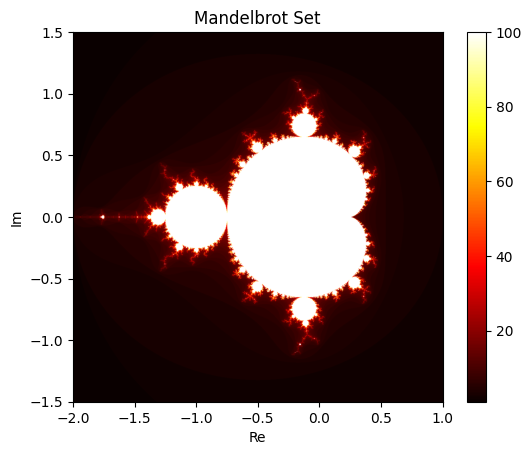

In [5]:
show_mandelbrot(mandelbrot_image, extent)

## Computing rows in parallel

Since the calculation for each pixel is independent of its neighbors, we don't have to process the image pixel by pixel. This is where the magic of parallelization comes in. We can speed it up by computing smaller parts of the algorithm in parallel. A simple and effective strategy is to split the image into horizontal rows and assign each row's calculation to a different worker. This way multiple parts of the Mandelbrot set can be generated simultaneously.

![Mandelbrot row-by-row processing](../res/mandelbrot_rows.png)

## Thread-per-row

With a plan for parallelization, let's explore our first implementation: threading. Python offers a set of tools to run multiple threads of execution concurrently. We'll adapt our naive algorithm to distribute the row calculations across several threads.



The [ThreadPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor) is a high-level tool in Python's `concurrent.futures` module for managing a pool of threads to execute tasks concurrently. It simplifies running asynchronous functions by creating and managing a set of worker threads, so you don't have to handle the thread lifecycle manually. Most often `ThreadPoolExecutor` will be used in one of two ways:
1. You can use `.submit(fn, /, *args)` function to submit tasks to the executor. The latter assigns them to an available thread, and returns a `Future` object that you can use to check the task's status or retrieve its result once it completes.
2. You can use `.map(fn, *iterables)` function, which works just like builtin `map()` - apply the function to every item in the list, but in parallel.

## **Task** 1.1:
*Please implement `generate_mandelbrot_threads` function which uses `ThreadPoolExecutor` to parallelize the Mandelbrot set generation, by following row-per-worker strategy.*

In [6]:
def compute_row(y, r1, ymin, height, max_iter):
    row = []
    imag = ymin + (y / height) * (abs(ymin) + abs(ymin))
    for x, real in enumerate(r1):
        c = complex(real, imag)
        row.append(mandelbrot(c, max_iter))
    return y, row


def generate_mandelbrot_threads(xmin, xmax, ymin, ymax, width, height, max_iter):
    r1 = np.linspace(xmin, xmax, width)
    result = np.empty((height, width))

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(compute_row, y, r1, ymin, height, max_iter)
            for y in range(height)
        ]
        for future in futures:
            y, row = future.result()
            result[y] = row

    return result

<img src="https://www.python.org/static/favicon.ico" alt="Python Icon" style="width:16px; vertical-align:middle;"> <span style="color:#76b900;font-size:120%">The behaviour of the following cell will be different when running with and withough the GIL.</span>

In [7]:
%%time
mandelbrot_image = generate_mandelbrot_threads(
    xmin, xmax, ymin, ymax, width, height, max_iter
)

CPU times: user 3.32 s, sys: 0 ns, total: 3.32 s
Wall time: 431 ms


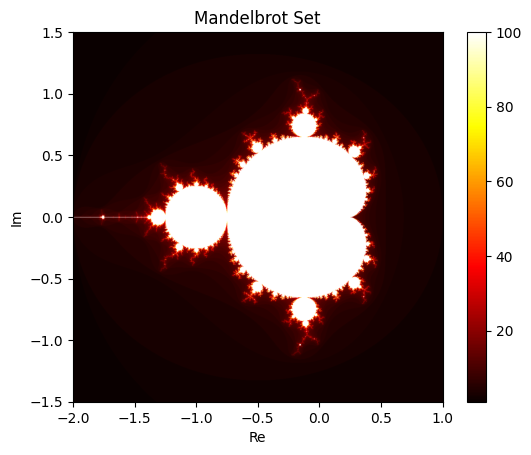

In [8]:
show_mandelbrot(mandelbrot_image, extent)

## Process-per-row

Another common approach is to use `multiprocessing`. Instead of threads, we'll use separate processes, each with its own Python interpreter and memory space. This allows us to achieve true parallelism on multi-core processors, as each process can run on a different core without being constrained by the GIL.

Let's implement the process-based parallelization using Python's multiprocessing module. We need refactor the code to create a pool of worker processes and distribute the Mandelbrot set's row computations among them. By comparing the execution time of this version with the naive implementation, you'll see a significant performance improvement.

To help us manage the pool of processes, we can use Python's [concurrent.futures.ProcessPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor). Its API is very similar to `ThreadPoolExecutor`. In fact, the first thing you may try is just to replace `ThreadPoolExecutor` with `ProcessPoolExecutor`!

## **Task** 1.2:
*Please implement `generate_mandelbrot_processes` function, which performs the parallelization using `ProcessPoolExecutor`.*

### Processes

In [9]:
def compute_row(args):
    y, width, xmin, xmax, ymin, ymax, height, max_iter = args
    row = np.empty(width)
    imag = ymin + (y / height) * (ymax - ymin)
    for x in range(width):
        real = xmin + (x / width) * (xmax - xmin)
        c = complex(real, imag)
        row[x] = mandelbrot(c, max_iter)
    return y, row


def generate_mandelbrot_processes(xmin, xmax, ymin, ymax, width, height, max_iter):
    # make the operation in-place in workers (this won't work)
    result = np.empty((height, width))
    args = [(y, width, xmin, xmax, ymin, ymax, height, max_iter) for y in range(height)]

    with ProcessPoolExecutor() as executor:
        for y, row in executor.map(compute_row, args):
            result[y] = row

    return result

In [10]:
%%time
mandelbrot_image = generate_mandelbrot_processes(
    xmin, xmax, ymin, ymax, width, height, max_iter
)

CPU times: user 370 ms, sys: 316 ms, total: 686 ms
Wall time: 588 ms


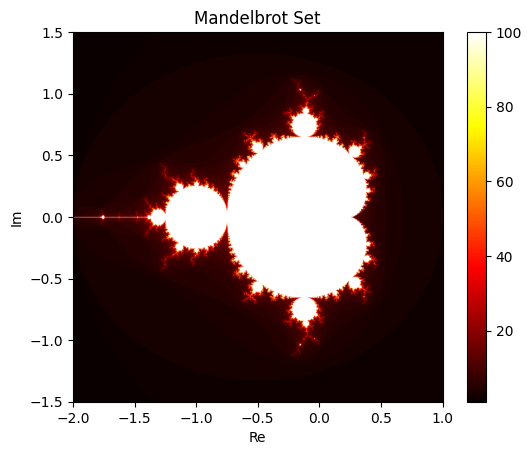

In [11]:
show_mandelbrot(mandelbrot_image, extent)

## Profiling

Excellent work implementing those parallel tasks! Now that you have the code running concurrently, the next logical step is to analyze its performance. For this, we'll use a powerful tool called a profiler. In this tutorial, we'll be using the NVIDIA Nsight profiler, which is conveniently built right into our JupyterLab environment, allowing us to see exactly how our code is executing on the hardware.

If you did not do it yet, please enable the profiler - you can use the description at the beginning of this tutorial.

### Gather profiles

To gather the profiles, select proper cell and trigger `Run and profile selected cells...` option. Nsight will generate a timestamped file inside `nsight-reports` directory. Please open this file in Nsight Profiler tab you've run earlier.

## **Task** 1.3:
*Please profile the cell responsible for parallelization within threads. <span style="color:#76b900;font-size:120%"><img src="https://www.python.org/static/favicon.ico" alt="Python Icon" style="width:16px; vertical-align:middle;"> You can do it in both GIL and No GIL interpreters</span>. Can you see the impact of the GIL?*

<hr><br>

# **Part 2:** Tools

<img src="https://www.python.org/static/favicon.ico" alt="Python Icon" style="width:16px; vertical-align:middle;"> <span style="color:#76b900;font-size:120%">Make sure to run this part within No GIL interpreter!</span>

In this part, we'll explore Python's tools for parallel programming. Two of them were already mentioned earlier: `ThreadPoolExecutor` and `ProcessPoolExecutor`. These tools provide a convenient way to manage a pool of workers, whether they are threads or processes, keeping them active and ready to be assigned jobs.

We'll explore two key concepts:
* **Locking mechanisms**, which prevent conflicts by ensuring only one thread can access a shared resource at a time.
* **Thread-local storage**, which provides a way to store data that is unique to each individual thread.

## Scenario: Auto-incrementing `Id` class

Let's implement an `Id` class that automatically assigns a unique value to each instance by incrementing a global counter. We'd like to make an assumption, that the total number of `ids` must not exceed 5,000. If it does, the constructor will raise a `RuntimeError`.

In [12]:
import threading
from res.test_utils import test_unique_ids

In [13]:
class Id:
    MAX_INSTANCES = 5_000

    _next = 0

    def __init__(self):
        self._value = Id._next_value()

    @classmethod
    def _next_value(cls):
        if cls._next >= Id.MAX_INSTANCES:
            raise RuntimeError("Number of Id instances cannot exceed 5,000")

        value = cls._next
        cls._next += 1

        return value

    def __int__(self):
        return self._value

Let's check if it works in a multithreaded context. The function `test_utils.test_unique_ids` creates 10 threads, each creating creating multiple ids. It then validates that the result is as expected.

In [14]:
Id._next = 0  # Reset the counter.


def generate_ids(n: int, ids: list[int]):
    for _ in range(n):
        try:
            ids.append(int(Id()))
        except RuntimeError:
            break


# test_unique_ids(generate_ids, Id.MAX_INSTANCES)

<img src="https://www.python.org/static/favicon.ico" alt="Python Icon" style="width:16px; vertical-align:middle;"> <span style="color:#76b900;font-size:120%">In the cell above we can actually see the benefit of having the GIL. Please run it in both interpreters. While the No GIL interpreter with raise an exception, the GIL-included one will work properly!</span>

Although the total number of ids should not exceed 5,000, it seems that more are created. You can try relaunching the cell above and see that number of ids created seems random.

This is an eample of a **race condition**: multiple threads are allowed to access a shared resource (here the instance count) and the result is dependent on the execution order. The root cause is that operations performed here are not atomic: checking if the instance count is greater than the threshold and increment it are two distinct operations. Consider the following scenario:
- The total instance count is 4999.
- Thread A checks that the instance count is lower than the threshold. It is.
- Before thread A increments the instance count, thread B also checks that it is lower than the threshold.
- Thread A increments the instance count. It is now 5000.
- Thread B increments the instance count. It is now 5001.

Even incrementing an integer is not an atomic operation. Something like `x = x + 1` must:
1. Load the value of `x`
2. Compute the result of `x + 1`
3. Store the new value in `x`

### <span style="color:#9D25DC">Curiosity Corner</span>:

Should you like to check precisely, what steps does the interpreter take to run `x = x + 1` statement, you may use Python's `dis` module, which disassembles the statement into CPython bytecode:

In [15]:
import dis

dis.dis("x = x + 1")

  0           RESUME                   0

  1           LOAD_NAME                0 (x)
              LOAD_CONST               0 (1)
              BINARY_OP                0 (+)
              STORE_NAME               0 (x)
              RETURN_CONST             1 (None)


### Solution: introducing critical section

One solution to solve race conditions is to lock the section(s) in which the race occurs. This ensures that only one thread at a given time can execute the code. The `threading` module provides many synchornization primitives and `threading.Lock` is one of them. Locks can be acquired and released using the `acquire` and `release` methods and they can also be used as context managers.

```python
from threading import Lock

lock = threading.Lock()
lock.acquire()
...  # Critical section: at most one thread can run this code at any given time
lock.release()
```

Let's rewrite the `Id` class to fix the race condition.

## **Task** 2.1:
*Please modify the implementation of `Id` class, to use `threading.Lock` to properly guard the code reached by multiple threads.*

In [16]:
class Id:
    MAX_INSTANCES = 5_000

    _lock = threading.Lock()
    _next = 0

    def __init__(self):
        self._value = Id._next_value()

    @classmethod
    def _next_value(cls):
        with cls._lock:
            if cls._next >= Id.MAX_INSTANCES:
                raise RuntimeError("Number of Id instances cannot exceed 5,000")

            value = cls._next
            cls._next += 1

        return value

    def __int__(self):
        return self._value

In [17]:
Id._next = 0  # Reset the counter.
test_unique_ids(generate_ids, Id.MAX_INSTANCES)

5000 unique ids generated!


### Wrapping up

- Unprotected shared state creates **race conditions**. This creates undefined behavior and must be avoided.
- Python comes with "batteries included" and the [`threading`](https://docs.python.org/3/library/threading.html) module offers multiple synchronization primitives. `threading.Lock` is one of them.
- Use context managers when possible. Failure to do so when working with locks can create **deadlocks**.

### <span style="color:#9D25DC">Curiosity Corner</span>:

Using locks introduces some overhead. While it may not be noticeable in simple programs, it can create bottlenecks in highly contended scenarios. Depending on the context, it might be worth considering using non-blocking data structures and algorithms.

For simple counters, atomic integers are a lock-free alternative. While the Python standard library doesn't provide such a type, libraries like [`ft_utils`](https://github.com/facebookincubator/ft_utils) fill this gap. Instances of [`AtomicInt64`](https://github.com/facebookincubator/ft_utils/blob/main/docs/concurrency_api.md#atomicint64) can be safely updated by multiple thread without locking.

```python
>>> from ft_utils.concurrency import AtomicInt64
>>> x = AtomicInt64()
>>> x.get()
0
>>> x += 1
>>> x.get()
1
```

## Scenario: Watermarking with context manager

In [18]:
import contextlib
import os
from IPython.display import display
from PIL import Image
from res.image_utils import apply_watermark, display_grid
from res.test_utils import test_watermarking

Let's consider another example. The `ImageRenderer` class has a `render` method that returns an image. The goal of this task is to create a context manager changing the behavior of `render` to add a watermark. The code would be used like this:

```python
>>> renderer = ImageRenderer("path/to/image.jpg")
>>> renderer.render()  # Original image
>>> with watermarked("My watermark"):
...     renderer.render()  # Watermarked image
```

We will use `Pillow` to load images. It can be used as follows:
```python
>>> from PIL import Image
>>> image = Image.open("path/to/image.jpg")
>>> image.load()
```

The last line is necessary in a multithreaded context as Pillow performs lazy loading.

## **Task** 2.2:
*Please write the `watermarked` context manager and modify the `render` method to apply watermarks when necessary. To help you with this, the module `image_utils` provides the function `apply_watermark` that takes a Pillow image and some text.*
```python
def apply_watermark(image: Image.Image, watermark: str) -> Image.Image:
    """Applies a text watermark to an image.
    
    Args:
        image: A Pillow Image object to which the watermark will be added.
        watermark: The string of text to use as the watermark.

    Returns:
        A new Pillow Image object with the watermark applied.
    """
```

In [19]:
class RenderContext:
    def __init__(self):
        self.watermark: str | None = None


render_context = RenderContext()


@contextlib.contextmanager
def watermarked(text: str):
    render_context.watermark = text
    try:
        yield
    finally:
        render_context.watermark = None


class ImageRenderer:
    def __init__(self, path: str | os.PathLike[str]):
        self._image = Image.open(path)
        self._image.load()

    def render(self) -> Image.Image:
        image = self._image

        if watermark := render_context.watermark:
            image = apply_watermark(image, watermark)

        return image

Let's check that the code works.

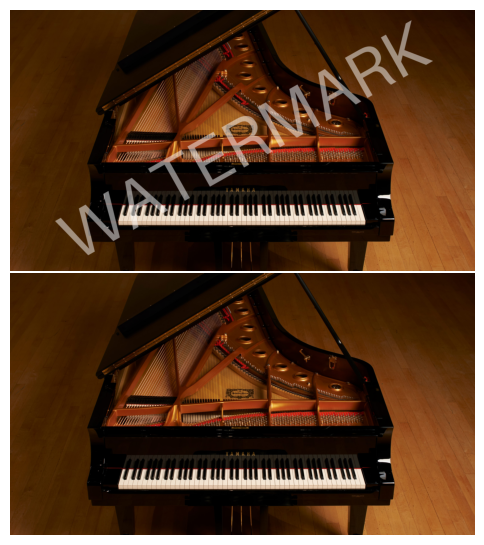

In [20]:
renderer = ImageRenderer("res/grand_piano.jpg")
base_image = renderer.render()

with watermarked("WATERMARK"):
    watermaked_image = renderer.render()

display_grid((watermaked_image, base_image), shape=(2, 1))

Let's now try if the code works with multiple threads. `image_utils.test_watermarking` launches four threads: the first three apply a watermark using the context manager and the last one keeps the image as it is.

In [21]:
def render_image(images: list[Image.Image], index: int, add_watermark: bool):
    if add_watermark:
        watermark = f"Watermark {index + 1}"
        with watermarked(watermark):
            image = renderer.render()
    else:
        image = renderer.render()

    images[index] = image


# test_watermarking(render_image)

Oops! The last image should not have a watermark. What just happened?

The `render_context` is a global variable and as such is shared between threads. When multiple threads set this variable at the same time, this creates a data race and there is no way to reliably predict the outcome.

A solution to this issue is to use **thread-local storage**, i.e. storage that is specific to each thread. Python provides the class [threading.local](https://docs.python.org/3/library/threading.html#thread-local-data) to achieve this. If a thread sets an attribute of a `threading.local` instance to a value, this is invisible to other threads which all have their separate, unique copies. `threading.local` may also be used as a base class for another class.

## **Task** 2.3:
*Please use Python's `threading.local` class to make `render_context` thread-local.*

In [22]:
class RenderContext(threading.local):
    def __init__(self):
        self.watermark: str | None = None


render_context = RenderContext()

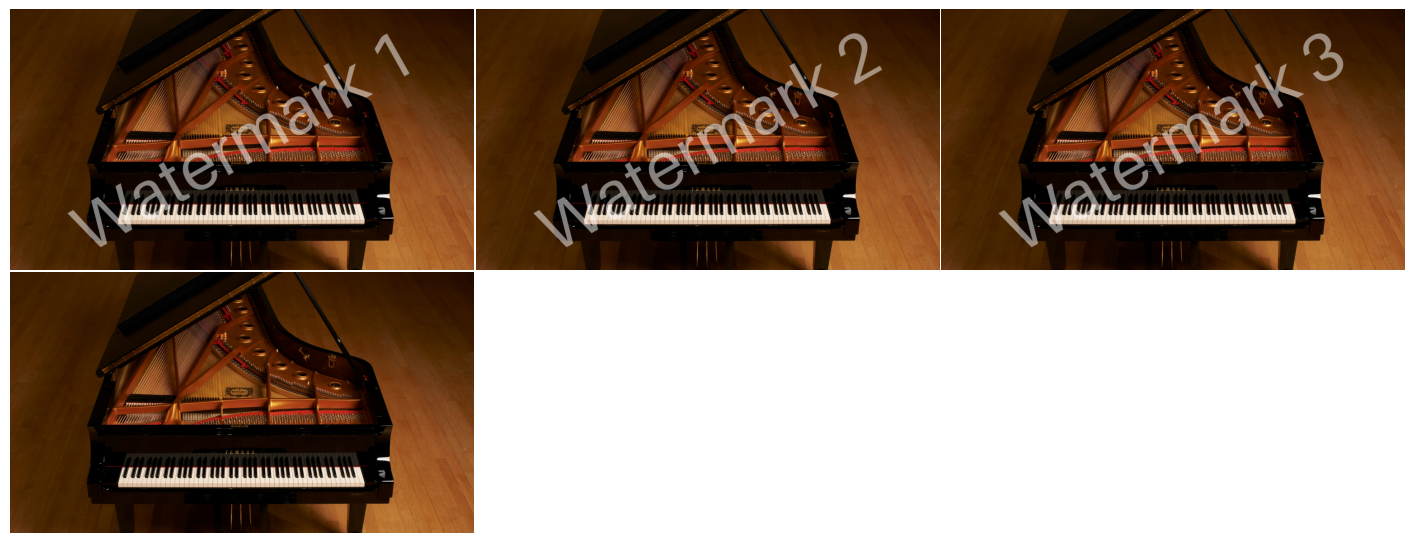

In [23]:
test_watermarking(render_image)

### Wrapping up

Thread-local storage allows each thread to have its own isolated version of some data. This can be achieved in Python by using `threading.local`.

There are multiple examples of thread local context managers, both in the Python standard library and in third party libraries. This is for instance the case of [context objects](https://docs.python.org/3/library/decimal.html#decimal.localcontext) in the `decimal` module, that allow tuning the behavior of decimal numbers. PyTorch also features multiple examples of thread local context managers, such as [`torch.no_grad`](https://docs.pytorch.org/docs/stable/generated/torch.no_grad.html).

<hr><br>

# **Part 3:** nvImageCodec

Usually, we forget that the image decoding operation even exists. We open a `.jpg` file, and it just works. But what's happening under the hood?

A JPEG file isn't a simple grid of pixels. It's a compressed data stream designed to make image files much smaller. The process of turning this compressed data back into a visible image that your computer can display is called **decoding**. This process involves several steps, such as parsing the headers, Huffman decoding, dequantization, Inverse Discrete Cosine Transform (IDCT) and color space conversion. This is a computationally intensive task, and as we'll see, where you do this work - on the CPU or the GPU - matters a lot.

In [24]:
# Utilities for Part 4
import io
import threading
import numpy as np
import matplotlib.pyplot as plt
import nvidia.nvimgcodec as nvic
from PIL import Image
from res.image_utils import show_image
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor


batch_size = 48
max_workers = 8
encoded_image = np.fromfile("res/grand_piano.jpg", np.uint8)
encoded_batch = np.stack([encoded_image] * batch_size)
test_image_shape = (2763, 4912, 3)
encoded_image_bio = io.BytesIO(encoded_image.tobytes())
encoded_batch_bio = [encoded_image_bio for _ in range(batch_size)]

## CPU image decoding

Let's start with the standard, most common way to handle images in Python: the [Pillow](https://pillow.readthedocs.io/en/stable/handbook/tutorial.html) library. When you use Pillow to open a JPEG, all the decoding work happens on the CPU.

### The Pillow API

The main function you'll use is [Image.open()](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open). However, to make our performance comparison fair, we need to eliminate the time it takes to read a file from the disk (I/O). Disk access is slow and variable, and we only want to measure the decoding speed.

To do this, we've loaded our JPEG file into an in-memory binary buffer using Python's [io.BytesIO](https://docs.python.org/3/library/io.html#io.BytesIO) (see `encoded_image_bio`). Think of `BytesIO` as a "fake file" that lives entirely in RAM. You can pass this object to `Image.open()` just like you would a real file.

**Important**: The implementation of `open()` is lazy! Calling `Image.open()` doesn't actually decode the image. Upon calling this function, Pillow parses the headers to get basic info like dimensions but postpones the expensive decoding work until you actually need the pixel data. To force the full decoding operation to happen, you need to explicitly access the pixel data or call `.load()` function on the object returned by `Image.open()`.

## **Task** 3.1:
*Please implement `decode_image_pil` function that takes the raw bytes of a JPEG, opens it with Pillow, and calls `.load()` to trigger the CPU-bound decoding.*

In [25]:
def decode_image_pil(encoded_image):
    img = Image.open(encoded_image)
    img.load()
    return img

Let's measure the time of decoding and visualize the result in the following two snippets

In [26]:
%%time
img = decode_image_pil(encoded_image_bio)

CPU times: user 31.7 ms, sys: 20 ms, total: 51.7 ms
Wall time: 51.5 ms


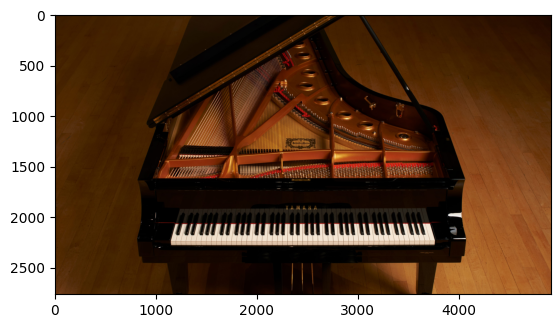

In [27]:
show_image(img)

## GPU image decoding

Let's move this workload from the CPU to the GPU. We'll use NVIDIA's [nvImageCodec](https://docs.nvidia.com/cuda/nvimagecodec/samples/nvimgcodec.html) library, a high-performance tool specifically designed for accelerating image and video decoding.<br>
`nvImageCodec` gives us two ways to use the GPU's power:
1. **Hardware Cores**: Modern NVIDIA GPUs have dedicated silicon blocks specifically for video and image decoding. These are highly efficient for formats like JPEG.
2. **CUDA Cores**: If a format isn't supported by the dedicated hardware, `nvImageCodec` can use the GPU's general-purpose CUDA cores to perform the decoding. This is still much faster than a CPU.

### The nvImageCodec API

The API is more explicit than Pillow's. The core component is the [Decoder](https://docs.nvidia.com/cuda/nvimagecodec/py_api.html#decoder) object. You create an instance of the `Decoder` and configure it for your needs (e.g., specifying output format). Then, you simply call its `.decode()` method and pass your image (as raw bytes).

Our implementation will involve creating a `nvImageCodec.Decoder` instance and then calling it with our image data. The result is a CUDA tensor sitting in the GPU's memory. The latter is especially useful, if our pipeline has a continuation, like deep learning inference or rendering.

## **Task** 3.2:
*Please implement `decode_image_nvic` function that takes two arguments: (1) instance of `nvic.Decoder` and (2) `np.array` with encoded image data.*

In [28]:
nvic_decoder = nvic.Decoder()


def decode_image_nvic(decoder, encoded_image):
    return decoder.decode(encoded_image)

*Please also implement the following code snippets:*
1. *Warming up the Decoder,*
2. *Benchmarking the decoding.*

In [29]:
%%time
# Warmup
_ = decode_image_nvic(nvic_decoder, encoded_image)

CPU times: user 24.4 ms, sys: 12 ms, total: 36.4 ms
Wall time: 36.2 ms


In [30]:
%%time
# Benchmark
img = decode_image_nvic(nvic_decoder, encoded_image)

CPU times: user 17.3 ms, sys: 7.94 ms, total: 25.2 ms
Wall time: 25.1 ms


Since the `.decode()` function performs image decoding on the GPU, the output of this function also resides in the GPU memory. We need to call `.cpu()` function to use it from the CPU.

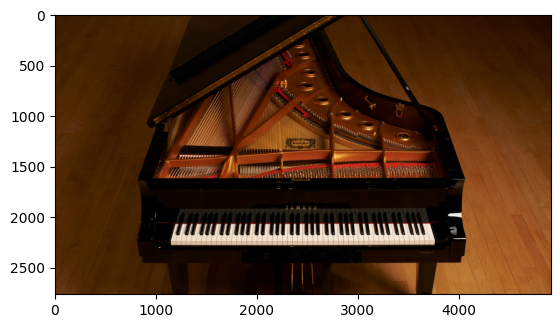

In [31]:
show_image(img.cpu())

## Scenario: image decoding parallelization

Imagine a real-time security service designed for **minimal response latency**. The system analyzes a continuous stream of events from a camera, processing one image at a time. This single-piece flow ensures that a new, potentially critical image is analyzed immediately upon arrival, avoiding any queue-related delays. We can parallelize the analysis of images, however we do not want to batch them - to minimize the latency, we'd like that every image is processed as soon as we get it.

### <span style="color:#9D25DC">Curiosity Corner</span>:

`nvImageCodec` actually has a batch API. Typically when using GPUs, you'd like to batch as many samples as possible, therefore leveraging the beauty of GPU architecture. Using `nvImageCodec` batch API is as simple as:

In [32]:
%%time
batch = decode_image_nvic(nvic_decoder, encoded_batch)

CPU times: user 899 ms, sys: 481 ms, total: 1.38 s
Wall time: 457 ms


However, in our example we would like to minimize the latency. Therefore, although we could use batch API to process the whole `encoded_batch` in one go, we want to parallelize decoding on the sample level.

## Parallel CPU decoding using **processes**

Let's implement the parallelization of image decoding operations. We can achieve this with the concept known from **Part 1** of the tutorial: multiprocessing.

We'll take our single-image PIL decoding function from **Task 3.1** and use `ProcessPoolExecutor.map()` to run it across our entire dataset of images.

## **Task** 3.3:
*Please implement `parallel_decoding_pil` function, which takes a batch of encoded images and decodes them in parallel using processes.*

### CPU decoding

In [33]:
encoded_batch_bio = [io.BytesIO(encoded_image.tobytes()) for _ in range(batch_size)]


def parallel_decoding_pil(encoded_batch):
    result = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for dec in executor.map(decode_image_pil, encoded_batch):
            result.append(dec)
    return result

In [34]:
%%time
decoded_images_pil = parallel_decoding_pil(encoded_batch_bio)

CPU times: user 1.46 s, sys: 1.19 s, total: 2.64 s
Wall time: 2.86 s


In [35]:
# Test
assert(len(decoded_images_pil) > 0)
for img in decoded_images_pil:
    assert img.size[0] == test_image_shape[1]
    assert img.size[1] == test_image_shape[0]
print("Test passed!")

Test passed!


## Parallel GPU decoding using **processes**

Time for the GPU part! However, before jumping to the implementation of process-parallelized GPU decoding, an important concept needs an explanation.

### `spawn` vs. `fork`
On Linux (which we are using in this tutorial), the default method for creating new processes is `forkserver`. This creates a lazy copy of the parent process, including its memory state. This is a problem for CUDA. The child process inherits the parent's address space, including CUDA context. This leads to CUDA initialization errors and crashes.

The solution is to use the `spawn` start method. `spawn` creates a brand-new, clean process, which doesn't inherit the parent's state. This is exactly what we need for each process to safely initialize its own CUDA context.

To set `spawn` as the start method, we can use the `multiprocessing` module:
```python
from multiprocessing import get_context
spawn_ctx = get_context("spawn")
ProcessPoolExecutor(mp_context=spawn_ctx, ...)  # Set `spawn` as the start method
```

### Pickleable objects
Multiprocessing introduces yet another challenge: **data transfer**. Since processes don't share memory by default, passing information between them requires specific mechanisms. There are generally two ways to handle data transfer between processes (in other words, Inter-Process Communication - IPC):
1. **Pipes** and
2. **Shared memory**.

Using Pipes, data is serialized and sent from one process to another. On the other hand, shared memory is a special block of memory, which can be accessed by multiple processes directly. The `ProcessPoolExecutor` conveniently abstracts away the details of IPC. A crucial requirement for IPC using Linux Pipes is that any object being transferred must be "pickleable" (serializable), and a common example of a pickleable object is a NumPy array. For true shared memory, you would need to use more specialized tools, like the `torch.multiprocessing.Queue`.

Sadly, it's impossible to run this part of the tutorial inside Jupyter Notebook. This stems from Jupyter's way of sandboxing the cells - those will not work with `spawn` as start method. We can overcome this limitation by using a regular Python file. The `nvic_process.py` file contains the template for implementing the GPU decoding paralellization in processes.

## **Task** 3.4:
*Please open `nvic_process.py` file and implement the `parallel_decoding_nvic` function inside, using the instructions above. To test the function, you can open a new tab in Jupyter with a terminal and run the Python file using shell, e.g.:*
```
user@6b9bf62e8e13:dli/task$ python nvic_process.py
```

The following snippets will allow us to benchmark the process-parallelized GPU image decoding.

In [36]:
import nvic_process
import importlib

_ = importlib.reload(nvic_process)

In [37]:
%%time
nvic_process.time()

CPU times: user 1.22 s, sys: 1.01 s, total: 2.23 s
Wall time: 3.63 s


## Parallel CPU image decoding using **threads**

Let's now leverage free-threaded Python. We can use the aforementioned [ThreadPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor), which creates multiple threads within the *same* process. These threads share memory, which makes passing data between them much cheaper than with processes.

## **Task** 3.5:
*Implement `parallel_decoding_pil` function, which uses `ThreadPoolExecutor` to parallelize image decoding.*

In [38]:
encoded_batch_bio = [io.BytesIO(encoded_image.tobytes()) for _ in range(batch_size)]

def parallel_decoding_pil(encoded_batch):
    result = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for dec in executor.map(decode_image_pil, encoded_batch):
            result.append(dec)
    return result

Let's test and benchmark the solution.

<img src="https://www.python.org/static/favicon.ico" alt="Python Icon" style="width:16px; vertical-align:middle;"> <span style="color:#76b900;font-size:120%">The behaviour of the following cell will be different when running with and withough the GIL.</span>

In [39]:
%%time
decoded_images = parallel_decoding_pil(encoded_batch_bio)

CPU times: user 2.32 s, sys: 488 ms, total: 2.81 s
Wall time: 398 ms


In [40]:
# Test
assert(len(decoded_images_pil) > 0)
for img in decoded_images:
    assert img.size[0] == test_image_shape[1]
    assert img.size[1] == test_image_shape[0]
print("Test passed!")

Test passed!


## Parallel GPU image decoding using **threads**

This is where we can truly shine by combining threads and the GPU.

There's one final sharp edge. Many GPU library objects, including the `nvImageCodec.Decoder`, are not **thread-safe**. If multiple threads try to use the same decoder object at the same time, you'll get race conditions or outright errors.

The solution is to ensure that each thread gets its own, separate decoder object. We can do this easily using the **thread-local** storage explained earlier in this tutorial. This pattern allows us to scale our GPU submission work across multiple threads, giving us a highly efficient and scalable decoding pipeline.

## **Task** 3.6:
*Please implement `parallel_decoding_nvic` function, which parallelized image decoding using threads as workers.*

In [41]:
thread_local_data = threading.local()


def get_decoder():
    if not hasattr(thread_local_data, "decoder"):
        thread_local_data.decoder = nvic.Decoder()
    return thread_local_data.decoder


def parallel_decoding_nvic_thread(encoded_image):
    decoder = get_decoder()
    return decoder.decode(encoded_image)


def parallel_decoding_nvic(encoded_images):
    result = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for dec in executor.map(parallel_decoding_nvic_thread, encoded_batch):
            result.append(dec)
    return result

As usual, let's benchmark and test the solution.

In [42]:
%%time
# Warmup
_ = parallel_decoding_nvic(encoded_batch)

CPU times: user 1 s, sys: 283 ms, total: 1.29 s
Wall time: 365 ms


<img src="https://www.python.org/static/favicon.ico" alt="Python Icon" style="width:16px; vertical-align:middle;"> <span style="color:#76b900;font-size:120%">The behaviour of the following cell will be different when running with and withough the GIL.</span>

In [43]:
%%time
decoded_batch = parallel_decoding_nvic(encoded_batch)

CPU times: user 994 ms, sys: 258 ms, total: 1.25 s
Wall time: 340 ms


In [44]:
# Test
assert(len(decoded_images_pil) > 0)
for img in decoded_batch:
    assert img.shape == test_image_shape
print("Test passed!")

Test passed!


## **Task** 3.7:
*Let's analyze the results. Please fill the variables below with the times recorded in the tasks above.*

In [45]:
from res.perf_numbers import show_recap

# Times in [ms]
measured_times = {
    "cpu_single": 35,
    "gpu_single": 24,
    "cpu_processes": 2770,
    "gpu_processes": 3370,
    "cpu_threads": 385,
    "gpu_threads": 325,
}
show_recap(**measured_times)

+-------------------+------------------+--------------------------+
| Execution model   |   Test time [ms] |   Throughput [samples/s] |
+===================+==================+==========================+
| CPU, single       |               35 |                  28.5714 |
+-------------------+------------------+--------------------------+
| GPU, single       |               24 |                  41.6667 |
+-------------------+------------------+--------------------------+
| CPU, processes    |             2770 |                  17.3285 |
+-------------------+------------------+--------------------------+
| GPU, processes    |             3370 |                  14.2433 |
+-------------------+------------------+--------------------------+
| CPU, threads      |              385 |                 124.675  |
+-------------------+------------------+--------------------------+
| GPU, threads      |              325 |                 147.692  |
+-------------------+------------------+--------

## **Task** 3.8: Profiling
*Analyzing the table above, which numbers are suspicious? Please profile those configurations to try to understand the performance regression.*

<hr><br>

# <font color="#76b900">**Wrapping Up**</font>

This notebook provided a hands-on exploration of parallel programming in Python, focusing on the impact of the Global Interpreter Lock (GIL) and the benefits of GIL-free (free-threaded) Python, especially when working with GPUs.

### Key Takeaways:
- **Understanding the GIL and its impact**:
	- The GIL restricts CPython to a single thread at a time, limiting parallelism on multi-core CPUs.
	- Removing the GIL (using free-threaded Python) allows true parallel execution, making Python more suitable for high-performance and concurrent applications.
- **Parallel programming techniques**:
	- *Multiprocessing*: Bypasses the GIL by using separate processes, enabling parallelism even in GIL-constrained environments.
    - *Threading*: Threads can share the memory address space, reducing the overhead on IPC for memory transfer.
- **Concurrency and thread safety**:
	- Shared state between threads can lead to race conditions. Proper synchronization (e.g., using `threading.Lock`) is essential.
	- Thread-local storage (`threading.local`) allows each thread to maintain its own state, preventing data corruption in concurrent scenarios.
- **Free-threaded Python impacts GPU workflows**:
    - When multiple processes access the same GPU, they must have different CUDA contexts. This stipulates CUDA context switching and the need of spawning processes instead of forking them.
	 
<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>